# Imports

In [1]:
#import libraries
import pandas as pd
from probatus.feature_elimination import ShapRFECV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats
import shap
import seaborn as sns
import pickle

In [2]:
#import dataframe
model2 = pd.read_csv('model2.csv')

# Pre-processing

In [3]:
#drop columns we do not need
model2 = model2.drop(columns=['subjectkey', 'Unnamed: 0', 'imgincl_rsfmri_include'])

In [4]:
#check missing values
missing_values = model2.isna().any()
missing_values_count = model2.isna().sum()
missing_values_count.value_counts()

0    248
dtype: int64

In [5]:
#seperate features and labels
X = model2.drop(['target'], axis=1)
y = model2['target'].values

#prepare train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# ShapRFECV Feature selection

In [20]:
#define random forest classifier
rf = RandomForestClassifier()

param_grid_rf = {'n_estimators': [5, 10, 15, 20, 25, 50, 100, 150],
                  'max_depth': [3, 6, 9],
                  'min_samples_split': np.arange(2, 10, 1),
                  'min_samples_leaf': np.arange(1, 10, 1)}

search_tuning = RandomizedSearchCV(rf, param_grid_rf)

# Run feature elimination
shap_elimination = ShapRFECV(
    clf=search_tuning, step=0.2, cv=10, scoring='roc_auc', n_jobs=3)
report = shap_elimination.fit_compute(X_train, y_train)

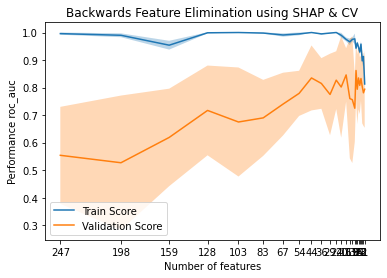

In [21]:
#Plot feature elimination
performance_plot = shap_elimination.plot()

In [22]:
print(report)

    num_features                                       features_set  \
1            247  [rsfmri_cor_ngd_au_scs_crcxlh, rsfmri_cor_ngd_...   
2            198  [rsfmri_cor_ngd_rst_scs_ptrh, rsfmri_cor_ngd_c...   
3            159  [rsfmri_cor_ngd_rst_scs_ptrh, rsfmri_cor_ngd_c...   
4            128  [rsfmri_cor_ngd_cerc_scs_agrh, rsfmri_cor_ngd_...   
5            103  [rsfmri_cor_ngd_cerc_scs_agrh, rsfmri_cor_ngd_...   
6             83  [rsfmri_cor_ngd_dsa_scs_cdelh, rsfmri_cor_ngd_...   
7             67  [rsfmri_cor_ngd_dsa_scs_cdelh, rsfmri_cor_ngd_...   
8             54  [rsfmri_cor_ngd_dsa_scs_cdelh, rsfmri_cor_ngd_...   
9             44  [rsfmri_cor_ngd_dsa_scs_cdelh, rsfmri_cor_ngd_...   
10            36  [rsfmri_cor_ngd_dsa_scs_cdelh, rsfmri_cor_ngd_...   
11            29  [rsfmri_cor_ngd_dsa_scs_cdelh, rsfmri_cor_ngd_...   
12            24  [rsfmri_cor_ngd_smh_scs_agrh, rsfmri_cor_ngd_d...   
13            20  [rsfmri_cor_ngd_smh_scs_agrh, rsfmri_cor_ngd_d...   
14    

In [23]:
#select the optimal amount of features (based on the plot) and store the name of the features into a variable
selected_features = shap_elimination.get_reduced_features_set(num_features=8)

In [24]:
#create new train/test with the pre-selected features from feature selection 
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_scaled = X_train_scaled[selected_features]
X_test_selected_scaled = X_test_scaled[selected_features]

In [40]:
#fit model with pre-selected features and do gridsearch
param_grid_rf = {'n_estimators': [5, 10, 15, 20, 25],
                  'max_depth': [2, 3, 4, 5, 6, 7, 8],
                  'min_samples_split': [8, 9, 10, 11, 12],
                  'min_samples_leaf': [2, 3, 4, 5, 6, 7]}

search = GridSearchCV(rf, param_grid_rf)

search.fit(X_train_selected, y_train)
print(search.best_estimator_)

RandomForestClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=10,
                       n_estimators=15)


[[6 4]
 [7 2]]
              precision    recall  f1-score   support

         0.0       0.46      0.60      0.52        10
         1.0       0.33      0.22      0.27         9

    accuracy                           0.42        19
   macro avg       0.40      0.41      0.39        19
weighted avg       0.40      0.42      0.40        19



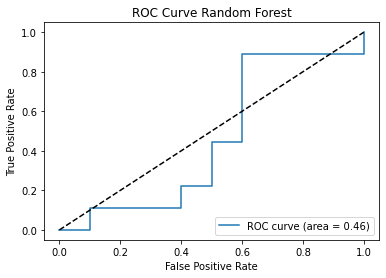

In [54]:
#update the model with parameters
rf_grid = RandomForestClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=10, n_estimators=15)
rf_grid.fit(X_train_selected, y_train)
y_pred_rf = rf_grid.predict(X_test_selected)
y_pred_probs_rf = rf_grid.predict_proba(X_test_selected)[:, 1]

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

#generate ROC curve values
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_pred_probs_rf)

#plot ROC curve
plt.plot(fpr_rf, tpr_rf, label="ROC curve (area = %0.2f)" % roc_auc_score(y_test, y_pred_probs_rf))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Random Forest")
plt.legend(loc="lower right")
plt.show()

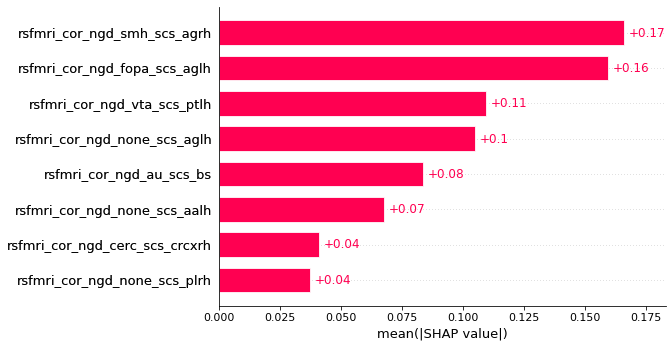

In [55]:
#shap feature importance
explainer = shap.Explainer(rf_grid.predict, X_test_selected)
shap_values = explainer(X_test_selected)
shap.plots.bar(shap_values)

# Logistic Regression

In [56]:
lr = LogisticRegression()

param_grid_lr = {
    'penalty': ['l1','l2', 'none'],  
    'C': [10, 1.0, 0.1, 0.01],
    'solver': ['sag', 'liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500, 1000, 2000, 5000]
}

search_lr = GridSearchCV(lr, param_grid_lr)
search_lr.fit(X_train_selected, y_train)

print(search_lr.best_estimator_)

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/skl

Setting penalty='none' will ignore the C and l1_ratio parameters
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/skl

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_sc

Setting penalty='none' will ignore the C and l1_ratio parameters
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit fai

Setting penalty='none' will ignore the C and l1_ratio parameters
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):


LogisticRegression(C=10, solver='sag')


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/data/szomerman/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty

[[3 7]
 [2 7]]
              precision    recall  f1-score   support

         0.0       0.60      0.30      0.40        10
         1.0       0.50      0.78      0.61         9

    accuracy                           0.53        19
   macro avg       0.55      0.54      0.50        19
weighted avg       0.55      0.53      0.50        19



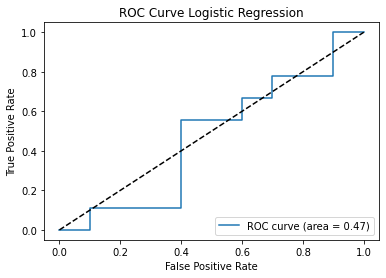

In [68]:
#fit model with pre-selected features als hyperparameters
lr_grid = LogisticRegression(C=10, solver='sag')
lr_grid.fit(X_train_selected_scaled, y_train)
y_pred_lr = lr_grid.predict(X_test_selected)
y_pred_probs_lr = lr_grid.predict_proba(X_test_selected)[:, 1]

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

#generate ROC curve values
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_pred_probs_lr)

#plot ROC curve
plt.plot(fpr_lr, tpr_lr, label="ROC curve (area = %0.2f)" % roc_auc_score(y_test, y_pred_probs_lr))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Logistic Regression")
plt.legend(loc="lower right")
plt.show()

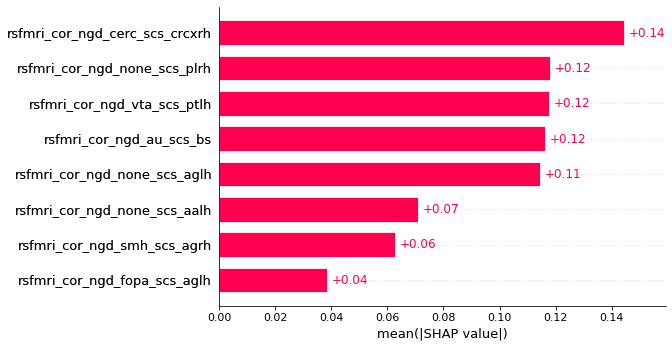

In [64]:
#shap feature importance
explainer_lr = shap.Explainer(lr_grid.predict, X_test_selected_scaled)
shap_values_lr = explainer_lr(X_test_selected_scaled)
shap.plots.bar(shap_values_lr)

# Support Vector Machine

In [60]:
svm = SVC()

param_grid_svm = {'C': [0.1, 1, 10],
                 'kernel': ['linear', 'rbf'],
                  'gamma': [0.1, 0.01, 0.001]
                 }
search_svm = GridSearchCV(svm, param_grid_svm)

search_svm.fit(X_train_selected_scaled, y_train)

print(search_svm.best_estimator_)

SVC(C=1, gamma=0.01)


[[6 4]
 [6 3]]
              precision    recall  f1-score   support

         0.0       0.50      0.60      0.55        10
         1.0       0.43      0.33      0.38         9

    accuracy                           0.47        19
   macro avg       0.46      0.47      0.46        19
weighted avg       0.47      0.47      0.46        19



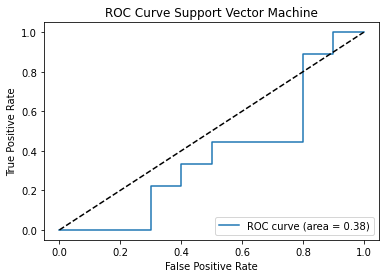

In [67]:
#fit model with pre-selected features and hyperparameters
svm_grid = SVC(C=1, gamma=0.1, probability=True)
svm_grid.fit(X_train_selected_scaled, y_train)
y_pred_svm = svm_grid.predict(X_test_selected_scaled)
y_pred_probs_svm = svm_grid.predict_proba(X_test_selected_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

#generate ROC curve values
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, y_pred_probs_svm)

#plot ROC curve
plt.plot(fpr_svm, tpr_svm, label="ROC curve (area = %0.2f)" % roc_auc_score(y_test, y_pred_probs_svm))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Support Vector Machine")
plt.legend(loc="lower right")
plt.show()

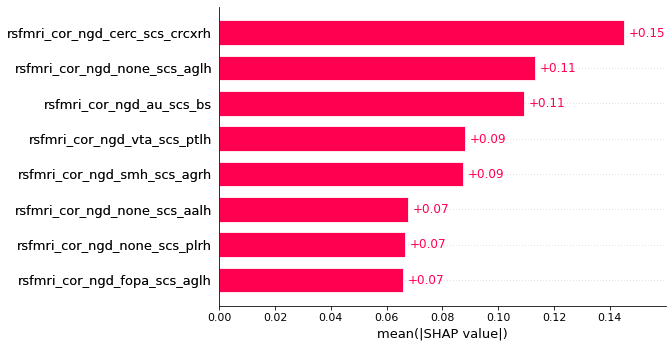

In [62]:
#shap feature importance
explainer_svm = shap.Explainer(svm_grid.predict, X_test_selected_scaled)
shap_values_svm = explainer_svm(X_test_selected_scaled)
shap.plots.bar(shap_values_svm)

In [66]:
#save needed variables to use for later visualization
data_model2 = {
    'y_train_2': y_train,
    'y_test_2': y_test,
    'X_train_selected_2': X_train_selected,
    'X_test_selected_2': X_test_selected,
    'X_train_selected_scaled_2': X_train_selected_scaled,
    'X_test_selected_scaled_2': X_test_selected_scaled,
    'y_pred_rf_2': y_pred_rf,
    'y_pred_lr_2': y_pred_lr,
    'y_pred_svm_2': y_pred_svm,
    'y_pred_probs_rf_2': y_pred_probs_rf,
    'y_pred_probs_lr_2': y_pred_probs_lr,
    'y_pred_probs_svm_2': y_pred_probs_svm,
    'fpr_rf_2': fpr_rf,
    'fpr_lr_2': fpr_lr,
    'fpr_svm_2': fpr_svm,
    'tpr_rf_2': tpr_rf,
    'tpr_lr_2': tpr_lr,
    'tpr_svm_2': tpr_svm,
    'threshold_rf_2': threshold_rf,
    'threshold_lr_2': threshold_lr,
    'threshold_svm_2': threshold_svm,
    'explainer_rf_2': explainer,
    'explainer_lr_2': explainer_lr,
    'explainer_svm_2': explainer_svm,
    'shap_values_rf_2': shap_values,
    'shap_values_lr_2': shap_values_lr,
    'shap_values_svm_2': shap_values_svm
}

with open("variables_model2.pkl", "wb") as file:
    pickle.dump((data_model2), file)
